In [26]:
import math, random, itertools
from collections import deque
import matplotlib.pyplot as plt
eps = 1e-9
inf = 1e9

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __lt__(self, p):
        return self.x < p.x
    def __add__ (self, p):
        return Point(self.x + p.x, self.y + p.y)
    def __sub__ (self, p):
        return Point(self.x - p.x, self.y - p.y)
    def __mul__(self, k):
        return Point(self.x * k, self.y * k)
    def dot(p, q):
        return p.x * q.x + p.y * q.y
    def cross(p, q):
        return p.x * q.y - p.y * q.x
    def slope(p, q):
        if p.x == q.x:
            return inf
        else:
            return (q.y - p.y) / (q.x - p.x)
    def point_in_hull(hull):
        if len(hull) > 0:
            weights_unscaled = [random.random() for _ in range(len(hull))]
            weights_scaled = [w / sum(weights_unscaled) for w in weights_unscaled]
            point = sum([hull[i] * weights_scaled[i] for i in range(len(hull))], Point(0, 0))
            return point
        else:
            return Point(0, 0)
    def __repr__(self):
        return str((round(self.x, 2), round(self.y, 2)))
    def __hash__(self):
        return hash((self.x, self.y))

class Halfplane:
    def __init__(self, p, q):
        self.p = p
        self.pq = q - p
        self.angle = math.atan2(self.pq.y, self.pq.x)
    def __lt__(self, h):
        return self.p.x < h.p.x if self.angle == h.angle else self.angle < h.angle
    def __repr__(self):
        return str(self.p) + " -> " + str(self.pq + self.p)
    def out(self, r):
        return Point.cross(self.pq, r - self.p) < -eps
    def intersect_point(g, h):
        alpha = Point.cross(h.p - g.p, h.pq) / Point.cross(g.pq, h.pq)
        return g.p + (g.pq * alpha)
    def cross(g, h):
        s = Point.cross(h.p - g.p, h.pq) / Point.cross(g.pq, h.pq)
        t = Point.cross(g.p - h.p, g.pq) / Point.cross(h.pq, g.pq)
        return 0 < s < 1 and 0 < t < 1
    def intersect_hull(halfplanes, MIN_COORD, MAX_COORD, SCALE):
        # https://cp-algorithms.com/geometry/halfplane-intersection.html
        box = [Point(MAX_COORD, SCALE * MAX_COORD), Point(MIN_COORD, SCALE * MAX_COORD), Point(MIN_COORD, SCALE * MIN_COORD), Point(MAX_COORD, SCALE * MIN_COORD)]

        for i in range(4):
            aux = Halfplane(box[i], box[(i + 1) % 4])
            halfplanes.append(aux)
        
        halfplanes.sort()
        dq = deque()

        for i in range(len(halfplanes)):
            while len(dq) > 1 and halfplanes[i].out(Halfplane.intersect_point(dq[-1], dq[-2])):
                dq.pop()
            while len(dq) > 1 and halfplanes[i].out(Halfplane.intersect_point(dq[0], dq[1])):
                dq.popleft()
            if len(dq) > 0 and math.fabs(Point.cross(halfplanes[i].pq, dq[-1].pq)) < eps:
                if Point.dot(halfplanes[i].pq, dq[-1].pq) < 0.0:
                    return []
                elif halfplanes[i].out(dq[-1].p):
                    dq.pop()
                else:
                    continue
            dq.append(halfplanes[i])

        while len(dq) > 2 and dq[0].out(Halfplane.intersect_point(dq[-1], dq[-2])):
            dq.pop()
        while len(dq) > 2 and halfplanes[-1].out(Halfplane.intersect_point(dq[0], dq[1])):
            dq.popleft()

        if len(dq) < 3:
            return []
        else:
            ret = []
            for i in range(len(dq)):
                p = Halfplane.intersect_point(dq[i], dq[(i + 1) % len(dq)])
                if hash(p) not in [hash(pp) for pp in ret]:
                    ret.append(p)
            return ret

def circ_to_swaps(circ):
    n = len(circ[0])
    swaps = []

    for i in range(len(circ) - 1):
        s = tuple([circ[i][j] for j in range(n) if circ[i][j] != circ[i + 1][j]])
        swaps.append(s)
    
    return swaps

def swaps_to_circ(swaps):
    n = max([s[1] for s in swaps]) + 1

    circ = []
    ej = [0 for _ in range(n - 1)]
    seq = [i for i in range(n)]
    circ.append(tuple(seq))
    
    for swap in swaps:
        i, j = swap
        i_ind, j_ind = seq.index(i), seq.index(j)
        seq[i_ind], seq[j_ind] = j, i
        ej[min(i_ind, j_ind)] += 1
        circ.append(tuple(seq))
    return circ, ej

def calculate_cr(ej):
  n = len(ej) + 1
  return int(sum([ej[j] * ((n - 2) * (n - 3) / 4 - j * (n - j - 2)) for j in range(n - 1)]))

def error_comp(swaps1, swaps2): # lcs problem
    m = len(swaps1)
    dp = [[0 for _ in range(m + 1)] for _ in range(m + 1)]

    for i in range(1, m + 1):
        for j in range(1, m + 1):
            if swaps1[i - 1] == swaps2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j],
                               dp[i][j - 1])
                
    return int(m - dp[m][m])

def pretty_print_circ(circ):
    n = len(circ[0])
    print("circular sequence:")
    pad = 2 * len(str(n))
    for c in circ:
        print("".join([str(i + 1).ljust(pad) for i in c]))

def pretty_print_points(points):
  print("points:")
  pad = 2 * max([len(str(p.x)) for p in points] + [len(str(p.y)) for p in points])
  print("x".ljust(pad), "y")
  for p in points:
    print(f"{p.x}".ljust(pad), f"{p.y}")

## Level 1

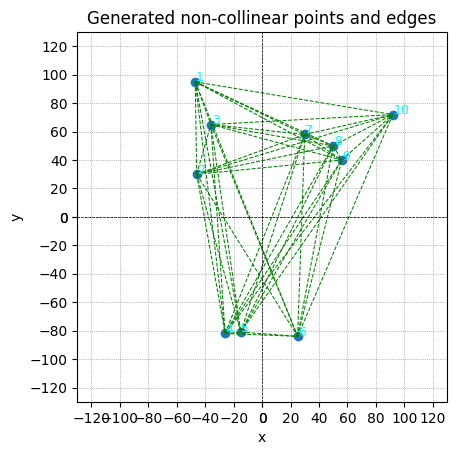

points:
x      y
-47    95
-46    30
-36    65
-26    -82
-15    -81
25     -84
30     58
50     50
56     40
92     72
circular sequence:
1   2   3   4   5   6   7   8   9   10  
2   1   3   4   5   6   7   8   9   10  
2   1   4   3   5   6   7   8   9   10  
2   4   1   3   5   6   7   8   9   10  
2   4   1   5   3   6   7   8   9   10  
4   2   1   5   3   6   7   8   9   10  
4   2   5   1   3   6   7   8   9   10  
4   5   2   1   3   6   7   8   9   10  
4   5   2   3   1   6   7   8   9   10  
4   5   2   3   6   1   7   8   9   10  
4   5   2   6   3   1   7   8   9   10  
4   5   2   6   3   1   7   9   8   10  
4   5   6   2   3   1   7   9   8   10  
4   5   6   2   3   1   9   7   8   10  
4   5   6   2   3   9   1   7   8   10  
4   5   6   2   3   9   7   1   8   10  
4   5   6   2   3   9   7   8   1   10  
4   5   6   2   3   9   8   7   1   10  
4   5   6   2   9   3   8   7   1   10  
4   5   6   2   9   8   3   7   1   10  
4   5   6   2   9   8   3   7   10  1   


In [27]:
FILE = False

if FILE:
  points = []
  with open("points.txt", "r") as f:
      for line in f.readlines():
          x, y = [float(i) for i in line.strip().split(" ")]
          points.append(Point(x, y))
  MIN_COORD = min([p.x for p in points] + [p.y for p in points])
  MAX_COORD = max([p.x for p in points] + [p.y for p in points])
else:
  MIN_COORD = -100
  MAX_COORD = 100
  n = 10
  points = []
  ct = 0 # track number of points generated
  while ct < n:
    p = Point(random.randint(MIN_COORD, MAX_COORD), random.randint(MIN_COORD, MAX_COORD)) # randomly generate point
    new_slopes = [Point.slope(p, pp) for pp in points] # find slopes with existing points
    if hash(p) not in [hash(pp) for pp in points] and len(set(new_slopes)) == len(new_slopes): # check if all slopes unique (otherwise, collinear triad exists)
      points.append(p) # add point
      ct += 1

points.sort()
n = len(points)

swaps = list(itertools.combinations([i for i in range(n)], 2))
swaps.sort(key = lambda p: Halfplane(points[p[0]], points[p[1]]))
circ, ej = swaps_to_circ(swaps)
cr = calculate_cr(ej)

x = [p.x for p in points]
y = [p.y for p in points]

STEP = math.ceil(2 * 10 ** math.floor(math.log10((MAX_COORD - MIN_COORD) / 10)))
SCALE = 1.1

plt.scatter(x, y, label="Generated points") # plot points
for ind, p in enumerate(points): # plot labels
  plt.text(p.x + 0.5, p.y + 0.5, f"{ind+1}", color='cyan', fontsize=9)
for e in itertools.combinations(points, 2): # plot edges
  x = [p.x for p in e]
  y = [p.y for p in e]
  plt.plot(x, y, color='green', linestyle='--', linewidth=0.75)

# visuals
plt.ylim(SCALE * MIN_COORD - STEP, SCALE * MAX_COORD + STEP)
plt.xlim(SCALE * MIN_COORD - STEP, SCALE * MAX_COORD + STEP)
ticks = [i for i in range(0, int(SCALE * MIN_COORD - STEP), -STEP)] + [i for i in range(0, int(SCALE * MAX_COORD + STEP), STEP)]
plt.yticks(ticks)
plt.xticks(ticks)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--') 
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.title('Generated non-collinear points and edges')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect("equal")
plt.show()
pretty_print_points(points)
pretty_print_circ(circ)
print("crossing number:", cr)

In [28]:
edges = [Halfplane(points[p[0]], points[p[1]]) for p in list(itertools.combinations([i for i in range(n)], 2))]
cr_bruteforce = 0
for pair in itertools.combinations(edges, 2):
    if Halfplane.cross(pair[0], pair[1]):
        cr_bruteforce += 1
print("crossing number (bruteforce):", cr_bruteforce)

crossing number (bruteforce): 140


In [29]:
edges = [Halfplane(points[p[0]], points[p[1]]) for p in list(itertools.combinations([i for i in range(n)], 2))]
ej = [0 for _ in range(n - 1)]
for e in edges:
    j = 0
    for p in points:
        if e.out(p):
            j += 1
    ej[j] += 1
cr_bruteforce2 = calculate_cr(ej)
print("crossing number (bruteforce):", cr_bruteforce2)

crossing number (bruteforce): 140


## Level 2

circular sequence:
1 2 3 4 5 
1 3 2 4 5 
3 1 2 4 5 
3 2 1 4 5 
3 2 4 1 5 
3 4 2 1 5 
3 4 2 5 1 
3 4 5 2 1 
3 5 4 2 1 
5 3 4 2 1 
5 4 3 2 1 


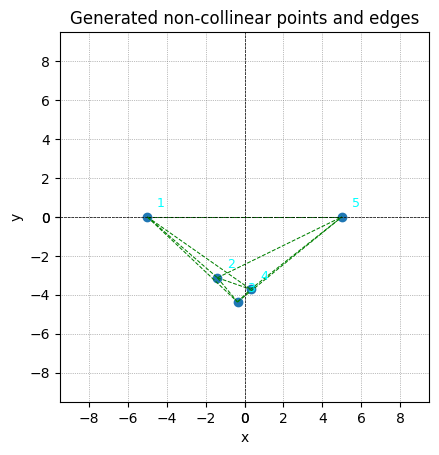

VERIFICATION
circular sequence:
1 2 3 4 5 
1 3 2 4 5 
3 1 2 4 5 
3 2 1 4 5 
3 2 4 1 5 
3 4 2 1 5 
3 4 2 5 1 
3 4 5 2 1 
3 5 4 2 1 
5 3 4 2 1 
5 4 3 2 1 
circular sequence matches target with 0/10 errors


In [30]:
FILE = True

if FILE:
  circ = []
  with open("circular_sequence.txt", "r") as f:
      for line in f.readlines():
          circ.append(tuple([int(i) - 1 for i in line.strip().split(" ")]))
  pretty_print_circ(circ)
  n = len(circ[0])
  MIN_COORD = -n
  MAX_COORD = n
else:
  n = 5
  MIN_COORD = -n
  MAX_COORD = n
  ind_points = []
  ct = 0 # track number of points generated
  while ct < n:
    p = Point(random.randint(MIN_COORD, MAX_COORD), random.randint(MIN_COORD, MAX_COORD)) # randomly generate point
    new_slopes = [Point.slope(p, pp) for pp in ind_points] # find slopes with existing points
    if hash(p) not in [hash(pp) for pp in ind_points] and len(set(new_slopes)) == len(new_slopes): # check if all slopes unique (otherwise, collinear triad exists)
      ind_points.append(p) # add point
      ct += 1
  swaps = list(itertools.combinations([i for i in range(n)], 2))
  swaps.sort(key = lambda p: Halfplane(points[p[0]], points[p[1]]))
  circ, ej = swaps_to_circ(swaps)


swaps = circ_to_swaps(circ)

points = [None for _ in range(n)]
points[0] = Point(MIN_COORD, 0)
points[-1] = Point(MAX_COORD, 0)

for i in range(1, n - 1):
    prev = [j for j in range(i)] + [n - 1]

    halfplanes = [Halfplane(points[i - 1], points[i - 1] + Point(0, -1))]
    for h in itertools.combinations(prev, 2):
        c = circ[swaps.index(h) + 1]
        if c.index(i) > c.index(h[1]):
            halfplanes.append(Halfplane(points[h[0]], points[h[1]]))
        else:
            halfplanes.append(Halfplane(points[h[1]], points[h[0]]))

    restr = [s for s in swaps if s[0] in prev + [i] and s[1] in prev + [i]]
    for j in prev:
        sw_ind = restr.index((min(i, j), max(i, j)))
        p_ind = sw_ind
        while p_ind >= 0 and i in restr[p_ind]:
            p_ind -= 1
        if p_ind >= 0:
           ref = restr[p_ind]
           halfplanes.append(Halfplane(points[j], points[j] + (points[ref[1]] - points[ref[0]]) * 0.5 * (-1 if j == n - 1 else 1)))
        a_ind = sw_ind
        while a_ind < len(restr) and i in restr[a_ind]:
            a_ind += 1
        if a_ind <= len(restr) - 1:
           ref = restr[a_ind]
           halfplanes.append(Halfplane(points[j], points[j] + (points[ref[0]] - points[ref[1]]) * 0.5 * (-1 if j == n - 1 else 1)))

    inter = Halfplane.intersect_hull(halfplanes, MIN_COORD, MAX_COORD, SCALE)
    points[i] = Point.point_in_hull(inter)

STEP = 2 * 10 ** math.floor(math.log10((MAX_COORD - MIN_COORD) / 10))
SCALE = 1.5

x = [p.x for p in points]
y = [p.y for p in points]

plt.scatter(x, y, label="Generated points") # plot points
for ind, p in enumerate(points): # plot labels
  plt.text(p.x + 0.5, p.y + 0.5, f"{ind+1}", color='cyan', fontsize=9)
for e in itertools.combinations(points, 2): # plot edges
  x = [p.x for p in e]
  y = [p.y for p in e]
  plt.plot(x, y, color='green', linestyle='--', linewidth=0.75)

# visuals
plt.ylim(SCALE * MIN_COORD - STEP, SCALE * MAX_COORD + STEP)
plt.xlim(SCALE * MIN_COORD - STEP, SCALE * MAX_COORD + STEP)
ticks = [i for i in range(0, int(SCALE * MIN_COORD - STEP), -STEP)] + [i for i in range(0, int(SCALE * MAX_COORD + STEP), STEP)]
plt.yticks(ticks)
plt.xticks(ticks)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--') 
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.title('Generated non-collinear points and edges')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect("equal")
plt.show()

print("VERIFICATION")
swaps_ver = list(itertools.combinations([i for i in range(n)], 2))
swaps_ver.sort(key = lambda p: Halfplane(points[p[0]], points[p[1]]))
circ_ver, edg_ver = swaps_to_circ(swaps_ver)
pretty_print_circ(circ_ver)
print("circular sequence matches target with", str(error_comp(swaps, swaps_ver)) + "/" + str(len(swaps)), "errors")
